In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import psycopg2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
from scipy.stats import stats
from scipy.stats import f_oneway
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed for 3d projection

In [2]:
class Taxi_analysis:
    def __init__(self, taxi):
        """
        Initialize the Taxi_analysis class with a taxi trip DataFrame.

        Parameters:
        -----------
        taxi : pd.DataFrame
            DataFrame containing taxi trip data.

        Expected Columns:
        ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
        'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
        'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
        'improvement_surcharge', 'total_amount', 'congestion_surcharge']
        """
        self.taxi = taxi

    def dataframe(self):
        """Returns the original taxi DataFrame."""
        return self.taxi

    def value_counts(self, columns):
        """
        Get value counts for one or more columns.

        Parameters:
        -----------
        columns : str or list
            Column name or list of column names.

        Returns:
        --------
        pd.Series or pd.DataFrame
            Value counts of the specified column(s).
        """
        if isinstance(columns, str):
            return self.taxi[columns].value_counts()
        else:
            return self.taxi[columns].apply(pd.Series.value_counts)

    def null_counts(self):
        """Returns the count of null/missing values per column."""
        return self.taxi.isnull().sum()

    def fill_missing_with_mean(self, columns_to_fill=['VendorID', 'passenger_count', 'RatecodeID', 'payment_type']):
        """
        Fill missing values in specified columns with their respective mean.

        Parameters:
        -----------
        columns_to_fill : list
            List of column names to fill with mean.
        """
        for col in columns_to_fill:
            if col in self.taxi.columns:
                mean_val = self.taxi[col].mean()
                self.taxi[col].fillna(mean_val, inplace=True)
                print(f"Filled missing values in '{col}' with mean: {mean_val}")

    def fill_na_with_Y_limit(self, limit=79229):
        """
        Fill missing values in the entire DataFrame with 'Y', up to a given limit.

        Parameters:
        -----------
        limit : int
            Maximum number of missing values to fill.
        """
        self.taxi.fillna('Y', limit=limit, inplace=True)
        print(f"Filled up to {limit} missing values with 'Y' in the dataset.")

    def calculate_trip_duration(self):
        """
        Calculate trip duration and add two columns:
        'trip_duration' (timedelta) and 'trip_duration_minutes' (float).
        """
        self.taxi['tpep_pickup_datetime'] = pd.to_datetime(self.taxi['tpep_pickup_datetime'])
        self.taxi['tpep_dropoff_datetime'] = pd.to_datetime(self.taxi['tpep_dropoff_datetime'])
        self.taxi['trip_duration'] = self.taxi['tpep_dropoff_datetime'] - self.taxi['tpep_pickup_datetime']
        self.taxi['trip_duration_minutes'] = self.taxi['trip_duration'].dt.total_seconds() / 60
        print("Trip duration columns added to the DataFrame.")

    def avg_fare_count(self):
        """Return average fare amount grouped by passenger count."""
        return self.taxi.groupby('passenger_count')['fare_amount'].mean().reset_index()

    def pass_count(self):
        """Return count of each unique passenger count."""
        return self.taxi['passenger_count'].value_counts()

    def common_trip(self):
        """Return the mode (most common) trip distance."""
        return self.taxi['trip_distance'].mode()[0]

    def largest_trip(self):
        """Return DataFrame of the top 10 largest trip distances."""
        return self.taxi.nlargest(10, 'trip_distance')

    def avg_per_trip(self):
        """Return the average fare amount per trip."""
        return self.taxi['fare_amount'].mean()

    def total_revenue(self):
        """Return a Series with total revenue per trip (fare + tip)."""
        return self.taxi['fare_amount'] + self.taxi['tip_amount']

    def payment_type(self):
        """Return average fare amount grouped by payment_type."""
        return self.taxi.groupby('payment_type')['fare_amount'].mean()

    def trip_distance(self):
        """Return DataFrame sorted by trip distance ascending."""
        return self.taxi.sort_values(by='trip_distance')

    # Plotting methods below

    def Surface_plot(self, col1, col2, col3):
        """
        3D scatter plot using Plotly.

        Parameters:
        -----------
        col1, col2, col3 : str
            Column names for x, y, and z axes respectively.
        """
        fig = px.scatter_3d(
            self.taxi,
            x=col1,
            y=col2,
            z=col3,
            color=col2,
            size_max=10,
            opacity=0.8,
            title=f'3D Plot of {col1}, {col2}, {col3}',
            labels={col1: col1, col2: col2, col3: col3}
        )
        fig.show()

    def Histogram(self, col):
        """
        Plot histogram with KDE.

        Parameters:
        -----------
        col : str
            Column name to plot.
        """
        plt.figure(figsize=(8, 5))
        sns.histplot(self.taxi[col], bins=50, kde=True, color="skyblue")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

    def Boxplot(self, col):
        """
        Plot boxplot.

        Parameters:
        -----------
        col : str
            Column name to plot.
        """
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=self.taxi[col], color="orange")
        plt.title(f"Boxplot of {col}")
        plt.xlabel(col)
        plt.show()

    def Violinplot(self, col):
        """
        Plot violin plot.

        Parameters:
        -----------
        col : str
            Column name to plot.
        """
        plt.figure(figsize=(8, 5))
        sns.violinplot(x=self.taxi[col], color="lightgreen")
        plt.title(f"Violin Plot of {col}")
        plt.xlabel(col)
        plt.show()

    def Scatterplot(self, col1, col2):
        """
        Plot scatter plot between two numeric columns.

        Parameters:
        -----------
        col1, col2 : str
            Column names for x and y axes.
        """
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=self.taxi, x=col1, y=col2, alpha=0.3)
        plt.title(f"Scatter Plot: {col1} vs {col2}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.show()

    def Densityplot(self, col1, col2):
        """
        Plot 2D KDE density plot.

        Parameters:
        -----------
        col1, col2 : str
            Column names for x and y axes.
        """
        plt.figure(figsize=(8, 5))
        sns.kdeplot(data=self.taxi, x=col1, y=col2, fill=True, cmap="mako")
        plt.title(f"Density Plot: {col1} vs {col2}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.show()

    def Pairplot(self):
        """Plot pairplot of all numerical columns."""
        cols = self.taxi.select_dtypes(include='number').columns.tolist()
        sns.pairplot(self.taxi[cols], diag_kind="kde", plot_kws={'alpha': 0.2})
        plt.suptitle("Pairplot of Numerical Features", y=1.02)
        plt.show()

    def Correlation_Heatmap(self, cols):
        """
        Plot correlation heatmap.

        Parameters:
        -----------
        cols : list
            List of column names to include in correlation.
        """
        corr = self.taxi[cols].corr()
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f",
                    linewidths=0.5, cbar_kws={'label': 'Correlation'})
        plt.title("Correlation Heatmap of Taxi Metrics", fontsize=14, weight="bold")
        plt.yticks(rotation=0)
        plt.show()

    @staticmethod
    def infer_sql_type(dtype):
        """
        Infers SQL type from pandas dtype.

        Parameters:
        -----------
        dtype : pandas dtype

        Returns:
        --------
        str : SQL datatype as string
        """
        if pd.api.types.is_integer_dtype(dtype):
            return "INT"
        elif pd.api.types.is_float_dtype(dtype):
            return "FLOAT"
        elif pd.api.types.is_bool_dtype(dtype):
            return "BOOLEAN"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "TIMESTAMP"
        else:
            return "TEXT"

    def generate_create_table_statement(self, table_name="Taxi_Trip_Data"):
        """
        Generate a SQL CREATE TABLE statement based on DataFrame columns and dtypes.

        Parameters:
        -----------
        table_name : str
            Name of the SQL table.

        Returns:
        --------
        str : CREATE TABLE SQL statement
        """
        columns = self.taxi.dtypes
        sql_columns = ",\n    ".join(
            [f'"{col}" {self.infer_sql_type(dtype)}' for col, dtype in columns.items()]
        )
        create_stmt = f"""CREATE TABLE IF NOT EXISTS {table_name} (
        {sql_columns}
        );"""
        return create_stmt

    def insert_to_postgres(self, conn_params, table_name="Taxi_Trip_Data"):
        """
        Create table and insert dataframe records into PostgreSQL.

        Parameters:
        -----------
        conn_params : dict
            Dictionary of connection parameters: dbname, user, password, host, port.
        table_name : str
            Name of the PostgreSQL table.
        """
        create_stmt = self.generate_create_table_statement(table_name)

        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()

            # Create table
            cur.execute(create_stmt)
            conn.commit()

            # Prepare insert statement
            columns = list(self.taxi.columns)
            placeholders = ", ".join(["%s"] * len(columns))
            insert_stmt = f"""INSERT INTO {table_name} ({", ".join(['"{}"'.format(col) for col in columns])}) VALUES ({placeholders})"""

            # Insert rows
            for _, row in self.taxi.iterrows():
                cur.execute(insert_stmt, tuple(row))

            conn.commit()
            cur.close()
            conn.close()
            print(f"Data inserted successfully into table {table_name}")

        except Exception as e:
            print(f"Error during PostgreSQL operation: {e}")

In [3]:
taxi_df = pd.read_csv('Taxi_Trip_Data.csv')

In [4]:
# Create an instance of the analysis class
taxi_analysis = Taxi_analysis(taxi_df)

In [5]:
taxi_analysis.dataframe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,01-01-2020 00:28,01-01-2020 00:33,1.0,1.20,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,01-01-2020 00:35,01-01-2020 00:43,1.0,1.20,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,01-01-2020 00:47,01-01-2020 00:53,1.0,0.60,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,01-01-2020 00:55,01-01-2020 01:00,1.0,0.80,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,01-01-2020 00:01,01-01-2020 00:04,1.0,0.00,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2.0,01-07-2020 07:42,01-07-2020 07:47,1.0,2.51,1.0,N,88,4,1.0,9.0,0.0,0.5,1.23,0.0,0.3,13.53,2.5
1048571,2.0,01-07-2020 07:33,01-07-2020 07:43,1.0,1.49,1.0,N,264,264,1.0,8.5,0.0,0.5,2.95,0.0,0.3,14.75,2.5
1048572,2.0,01-07-2020 07:54,01-07-2020 08:11,1.0,3.53,1.0,N,186,13,1.0,14.5,0.0,0.5,5.34,0.0,0.3,23.14,2.5
1048573,2.0,01-07-2020 07:17,01-07-2020 07:20,1.0,0.54,1.0,N,262,236,1.0,4.0,0.0,0.5,1.46,0.0,0.3,8.76,2.5


In [6]:
taxi_analysis.value_counts("passenger_count")

passenger_count
1.0    713728
2.0    175357
3.0     49679
5.0     38766
4.0     28290
6.0     22820
0.0     17782
7.0        11
8.0         6
9.0         5
Name: count, dtype: int64

In [7]:
taxi_analysis.null_counts()

VendorID                 2131
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          2131
trip_distance               0
RatecodeID               2131
store_and_fwd_flag       2131
PULocationID                0
DOLocationID                0
payment_type             2131
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge        0
dtype: int64

In [8]:
taxi_analysis.fill_missing_with_mean()

Filled missing values in 'VendorID' with mean: 1.6786765464754922
Filled missing values in 'passenger_count' with mean: 1.583992072198799
Filled missing values in 'RatecodeID' with mean: 1.0750274262167876
Filled missing values in 'payment_type' with mean: 1.328451403037334


C:\Users\hi\AppData\Local\Temp\ipykernel_20748\3088686228.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.taxi[col].fillna(mean_val, inplace=True)


In [9]:
taxi_analysis.fill_na_with_Y_limit()

Filled up to 79229 missing values with 'Y' in the dataset.


In [10]:
taxi_analysis.null_counts()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
dtype: int64

In [11]:
#taxi_analysis.calculate_trip_duration()
taxi_analysis.dataframe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,01-01-2020 00:28,01-01-2020 00:33,1.0,1.20,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,01-01-2020 00:35,01-01-2020 00:43,1.0,1.20,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,01-01-2020 00:47,01-01-2020 00:53,1.0,0.60,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,01-01-2020 00:55,01-01-2020 01:00,1.0,0.80,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,01-01-2020 00:01,01-01-2020 00:04,1.0,0.00,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2.0,01-07-2020 07:42,01-07-2020 07:47,1.0,2.51,1.0,N,88,4,1.0,9.0,0.0,0.5,1.23,0.0,0.3,13.53,2.5
1048571,2.0,01-07-2020 07:33,01-07-2020 07:43,1.0,1.49,1.0,N,264,264,1.0,8.5,0.0,0.5,2.95,0.0,0.3,14.75,2.5
1048572,2.0,01-07-2020 07:54,01-07-2020 08:11,1.0,3.53,1.0,N,186,13,1.0,14.5,0.0,0.5,5.34,0.0,0.3,23.14,2.5
1048573,2.0,01-07-2020 07:17,01-07-2020 07:20,1.0,0.54,1.0,N,262,236,1.0,4.0,0.0,0.5,1.46,0.0,0.3,8.76,2.5


In [12]:
# Average fare per passenger count
avg_fare = taxi_analysis.avg_fare_count()
avg_fare

,passenger_count,fare_amount
0,0.000000,12.735917
1,1.000000,12.647203
2,1.583992,39.863806
3,2.000000,13.673113
4,3.000000,13.763742
5,4.000000,14.639706
6,5.000000,12.710406
7,6.000000,12.732080
8,7.000000,66.476364
9,8.000000,54.280000


In [13]:
# Counts of passenger counts
passenger_counts = taxi_analysis.pass_count()
passenger_counts

passenger_count
1.000000    713728
2.000000    175357
3.000000     49679
5.000000     38766
4.000000     28290
6.000000     22820
0.000000     17782
1.583992      2131
7.000000        11
8.000000         6
9.000000         5
Name: count, dtype: int64

In [14]:
# Most common trip distance
common_distance = taxi_analysis.common_trip()
print("Most common trip distance:", common_distance)

Most common trip distance: 1.0


In [15]:
# Largest 10 trips by distance
largest_trips = taxi_analysis.largest_trip()
largest_trips

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
566885,2.0,01-04-2020 12:52,01-04-2020 17:23,4.0,259.22,5.0,N,140,265,2.0,575.0,0.0,0.0,0.00,0.00,0.3,577.80,2.5
773002,1.0,01-05-2020 13:45,01-05-2020 16:34,1.0,168.40,5.0,N,92,265,2.0,575.0,0.0,0.0,0.00,21.12,0.3,596.42,0.0
487894,2.0,01-03-2020 21:49,01-03-2020 23:40,2.0,110.51,5.0,N,132,265,1.0,370.0,0.0,0.0,0.00,0.00,0.3,370.30,0.0
74956,2.0,01-01-2020 10:45,01-01-2020 12:24,1.0,100.15,1.0,N,132,265,1.0,253.0,0.0,0.5,5.00,22.74,0.3,281.54,0.0
680805,2.0,01-04-2020 21:59,01-04-2020 23:46,1.0,96.35,5.0,N,230,265,1.0,200.0,0.0,0.0,0.00,0.00,0.3,202.80,2.5
861992,1.0,01-06-2020 04:27,01-06-2020 07:04,1.0,95.80,5.0,N,48,265,2.0,0.0,0.0,0.0,0.00,13.75,0.3,14.05,0.0
593767,2.0,01-04-2020 14:19,01-04-2020 16:03,2.0,94.17,4.0,N,161,265,2.0,467.5,0.0,0.5,0.00,10.50,0.3,481.30,2.5
810310,1.0,01-05-2020 17:40,01-05-2020 19:51,0.0,93.50,4.0,N,132,265,4.0,428.5,0.0,0.5,0.00,6.12,0.3,435.42,0.0
403989,2.0,01-03-2020 13:38,01-03-2020 15:37,1.0,92.06,1.0,N,132,265,2.0,235.5,0.0,0.5,0.00,6.12,0.3,242.42,0.0
967339,1.0,01-06-2020 16:54,01-06-2020 20:00,1.0,86.00,4.0,N,113,62,1.0,398.5,3.5,0.5,166.02,12.24,0.3,581.06,2.5


In [16]:
# Average fare amount per trip
average_fare = taxi_analysis.avg_per_trip()
print("Average fare per trip:", average_fare)

Average fare per trip: 12.987493302815725


In [17]:
# Total revenue per trip (fare + tip)
total_revenue = taxi_analysis.total_revenue()
print(total_revenue.head())

0    7.47
1    8.50
2    7.00
3    6.86
4    3.50
dtype: float64


In [18]:
# Average fare by payment type
payment_stats = taxi_analysis.payment_type()
print(payment_stats)

payment_type
1.000000    13.266469
1.328451    39.863806
2.000000    12.399875
3.000000     8.133543
4.000000     1.384765
Name: fare_amount, dtype: float64


In [19]:
# Sorted DataFrame by trip distance
sorted_trips = taxi_analysis.trip_distance()
sorted_trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
959555,2.0,01-06-2020 16:56,01-06-2020 17:54,1.0,-22.18,5.0,N,140,210,2.0,58.92,0.0,0.5,0.0,6.12,0.3,65.84,0.0
789549,2.0,01-05-2020 15:36,01-05-2020 16:07,1.0,-9.29,5.0,N,225,233,2.0,21.41,0.0,0.5,0.0,12.24,0.3,34.45,0.0
907141,2.0,01-06-2020 10:43,01-06-2020 10:49,1.0,-1.79,5.0,N,145,193,1.0,9.20,0.0,0.5,2.0,0.00,0.3,13.95,0.0
974199,2.0,01-06-2020 17:03,01-06-2020 17:11,1.0,-1.25,5.0,N,193,7,1.0,8.20,0.0,0.5,1.0,0.00,0.3,11.95,0.0
278284,2.0,01-02-2020 17:50,01-02-2020 17:54,1.0,-0.88,5.0,N,193,193,1.0,7.20,0.0,0.5,1.6,0.00,0.3,11.55,0.0


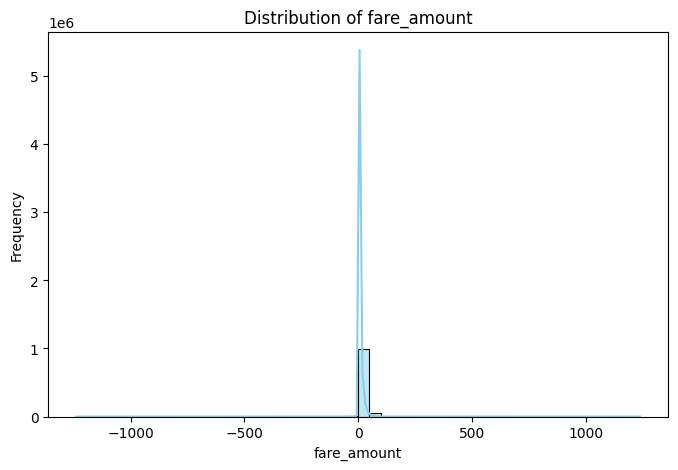

In [22]:
# Plot a histogram of fare_amount
taxi_analysis.Histogram('fare_amount')

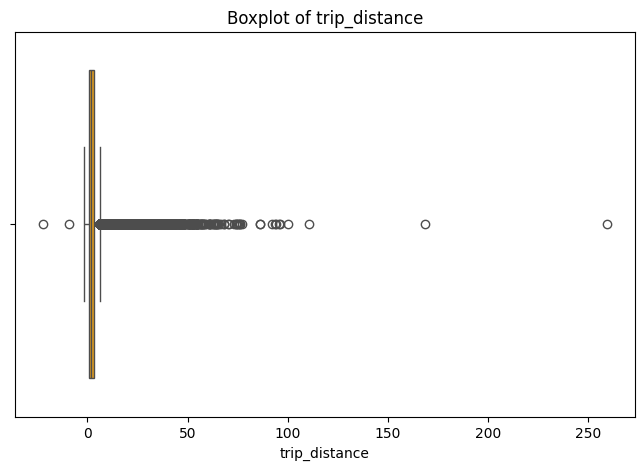

In [23]:
# Plot a boxplot of trip_distance
taxi_analysis.Boxplot('trip_distance')

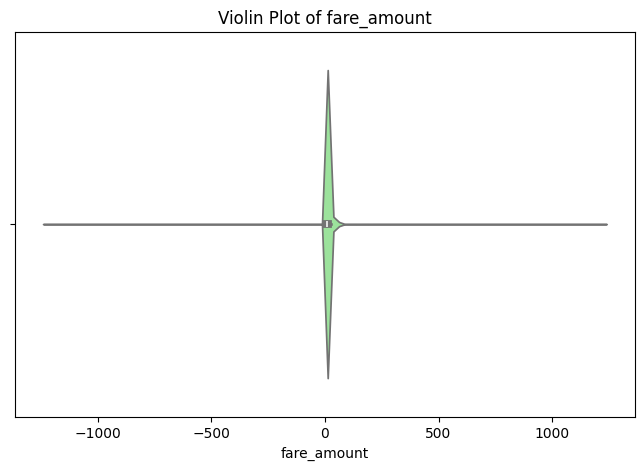

In [24]:
# Plot a violin plot of fare_amount
taxi_analysis.Violinplot('fare_amount')

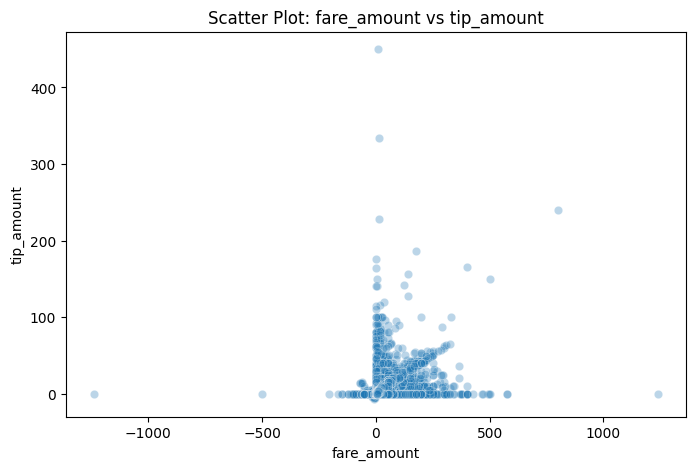

In [27]:
# Scatter plot of fare_amount vs tip_amount
taxi_analysis.Scatterplot('fare_amount', 'tip_amount')

In [ ]:
# 3D scatter plot of fare_amount, tip_amount, improvement_surcharge
taxi_analysis.Surface_plot('fare_amount', 'tip_amount', 'improvement_surcharge')

In [ ]:
# Density plot of fare_amount vs tip_amount
#taxi_analysis.Densityplot('fare_amount', 'tip_amount')

In [ ]:
# Pairplot for all numerical columns
#taxi_analysis.Pairplot()

In [ ]:
# Correlation heatmap of selected columns
#taxi_analysis.Correlation_Heatmap(['fare_amount', 'tip_amount', 'trip_distance', 'total_amount'])

In [ ]:
print(taxi_analysis.generate_create_table_statement())

In [ ]:
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "901473R",
    'host': "localhost",
    'port': "5432"
}
taxi_analysis.insert_to_postgres(conn_params, table_name="taxi_trip_data")
